# 1.1 PyTorch Basics

# Table of Contents

- #### 1.1. Basic autograd example 1
- #### 1.2. Basic autograd example 2
- #### 1.3. Loading data from numpy
- #### 1.4. Implementing the input pipline
- #### 1.5. Input pipline for custom dataset
- #### 1.6. Using pretrained models
- #### 1.7. Save and load models 




### (0. Imports)

Let's import torch, torchvision and some of their modules

In [ ]:
import torch 
import torch.nn as nn
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import numpy as np
# we also import pyplot and let jupyter show our plots with 
# the magic command %matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Basic autograd example 1

Gradient Checking. When we perform some operation with tensors (requiring gradients) and then we call `backward()` on a scalar tensor (i.e. 0-dimensional), the gradients w.r.t. the tensor for which we call the `backward()` method get stored in the `grad` attribute. We can thus inspect it by i.e. printing it.

In [ ]:
# Create tensors
# torch.tensor is the recommended way to build a new tensor from existing data, copying them
x = torch.tensor([1], requires_grad=True, dtype=torch.float)
w = torch.tensor([2], requires_grad=True, dtype=torch.float)
b = torch.tensor([3.0], requires_grad=True)

# Build a computation graph
y = w * x + b
print(x.grad)
print(w.grad)
print(b.grad)

What values should `dy/dx`, `dy/dw` and `dy/db` take?

    dy/dx = w # = 2
    dy/dw = x # = 1
    dy/db = 1


In [ ]:
# Compute gradients
y.backward()

# Print out the gradients
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

## 2. Basic autograd example 2

Let's see a slightly more complex operation with tensors, taking few steps towards building a neural network.

In [ ]:
# Create two random tensors, 5x3 and 5x2 (rows major)
x = torch.randn(5, 3)
y = torch.randn(5, 2)

# Build a linear layer with 3 input features and 2 output features,
# that is a function that computes y = x * A^T + b
# x is the input data, A is the weight matrix and b is the bias, both A and b are parameters of the function.
# Having 3 input features means that x will be a matrix of size Nx3, for some N,
# and having 2 output features means that y will have size Nx2.
# Note how N inputs of size 3 get processed at once resulting N outputs of size 2: N is often called batch size
linear = nn.Linear(3, 2)
print("w: ", linear.weight)
print("b: ", linear.bias)
print("y: ", linear(x))

### A simple Linear Regression

The point of computing gradients is that, given a function, we can compute how much the parameters of the function influence the result. For example, in the Linear function above, we can change `A` and `b` to influence the outcome `y`, given an input `x`. This means that, by tweaking the parameters, we can build a linear function that behaves as we desire.

In our case, we want to tweak `A` and `b` so that the `linear` function will transform the `x` random tensor we build earlier into the `y` random tensor.

To do so, we first define a `criterion` that is used to quantify how much the output of `linear(x)` is near to the desired value `y`. We will use Mean Squared Error (loss) function, in this case.
In addition, we need to define an `optimizer`: a strategy to modify the function parameters so that the loss is progressively reduced. 

In [ ]:
# Build a Loss function, which tells us the distance between two tensors
criterion = nn.MSELoss()
# Build an optimizer (Stochastic Gradient Descent, in this case), that will tweak the
# parameters of the linear function using the gradients
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# The learning process is iterative and begins with evaluating the function over the input
pred = linear(x)

# We can now measure how far is the "predicted" output to the desired output, y
loss = criterion(pred, y)
print('loss: ', loss.item())  # Use .item() to convert a 0-dimensional tensor (scalar) to a Python number

In [ ]:
# We can now compute the gradients of the loss function:
# how do linear's parameters influence the loss value?
loss.backward()

# Print out the gradients w.r.t the parameters
print('dL/dw: ', linear.weight.grad)
print('dL/db: ', linear.bias.grad)

The gradients are the derivative of the function, therefore if we modify the parameters of the linear function by adding the gradients, the loss shall increase. Let's verify this esperimentally: let's recreate the linear function by altering the parameters.

In [ ]:
A = linear.weight + linear.weight.grad
b = linear.bias + linear.bias.grad
# Transpose A by swapping dimension 0 with dimension 1, then, do matrix multiplication
updated_pred = x @ A.transpose(0, 1) + b
print(criterion(updated_pred, y).item())  # This should increase

The Stochastic Gradient Descent optimizier does something similar, but, instead of adding the derivative to the parameters as we just did, subtracts them so that the loss decreases. Note that the gradient is first scaled by a learning rate (`lr = 0.01` above) to avoid doing steps which are too large.

Let's see how's done in PyTorch.

In [ ]:
# Perform one optimization step of SGD.
# Note that optimizer only knows the parameters of the Linear layer and nothing more,
# because it uses the gradients of the loss function w.r.t. the parameters.
optimizer.step()

# You can also do optimization manually, e.g.:
# linear.weight.data.sub_(0.01 * linear.weight.grad.data)
# linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after optimization.
pred = linear(x)
loss = criterion(pred, y)
print('loss after 1 step optimization: ', loss.item())

## 3. Loading data from numpy

Numpy and PyTorch have a similar API (check issue #2228 on PyTorch repo for more on this), and Numpy arrays and Torch's Tensors shares the same data, so that we can pass from and to each other almost for free (on the CPU), for example:

In [ ]:
a = np.array([[1,2], [3,4]])
b = torch.from_numpy(a)      # convert numpy array to torch tensor
c = b.numpy()                # convert torch tensor to numpy array

<img style="height: 400px;" src="../imgs/img1.png"></img>

### torch.utils.data
impelemtations for convenience classes for datasets, samplers and `DataLoader`

http://pytorch.org/docs/master/data.html

### torchvision

implementations for popular datasets, model architectures, image transformations

http://pytorch.org/docs/master/torchvision/

## 4. Implementing the input pipline

The torchvision package includes datasets, implementations of popular architectures, and common image transformations for computer vision. 

we will now see how to load data and iterate through it using **torch.data.utils**' **dataset** module.

We won't use this dataset later, so you can skip the download by not executing the following cell.

# Example: CIFAR10 Dataset

- 32x32 images belonging to 10 disjoint classes

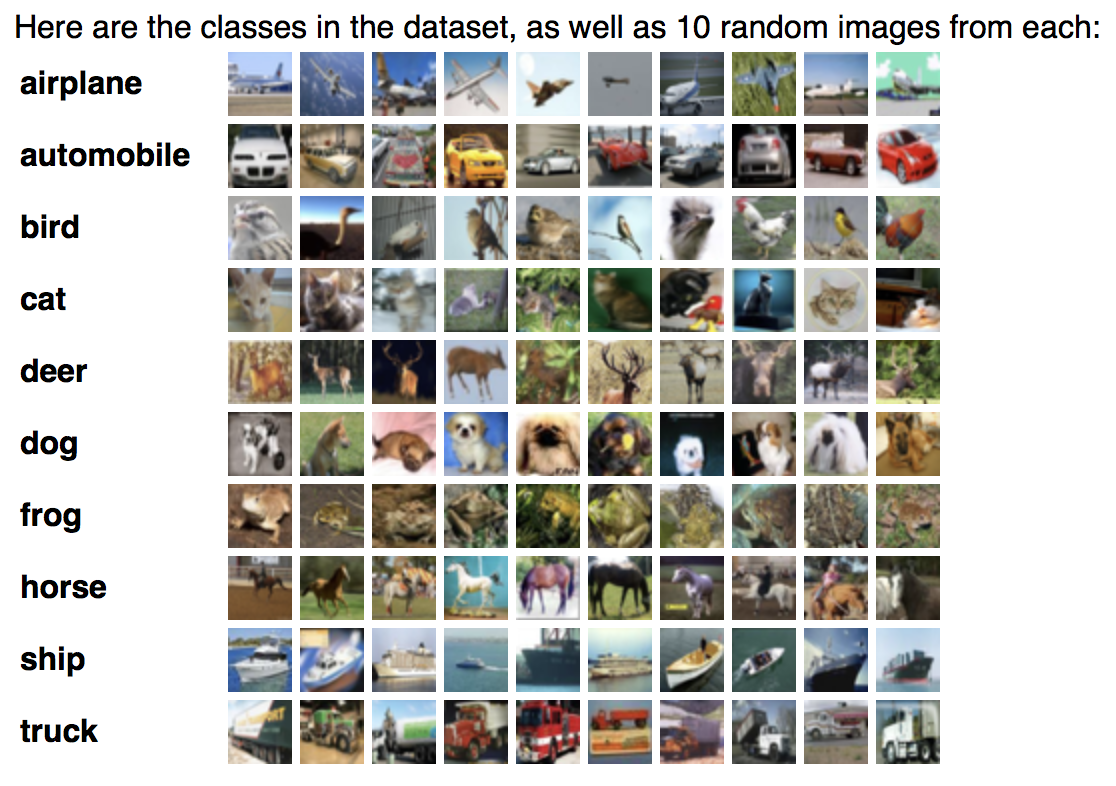</img>



In [ ]:
# Download and construct dataset.
# all args are implemetation-dependant
# https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py
train_dataset = dsets.CIFAR10(root='../data/cifar',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

# Select one data pair (read data from disk).
image, label = train_dataset[0]
print(image.size())
print(label)

Take a look at the available transforms using `dir(transforms)`

In [ ]:
# Data Loader (this provides queue and thread in a very simple way).
# this object creates batches for us by iteratively calling dataset's __getitem__
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=2)

# When iteration starts, queue and thread start to load dataset from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

# Actual usage of data loader is as below.
for images, labels in train_loader:
    # Your training code should be written here
    pass

images are automatically transformed, thanks to **torchvision.transforms.ToTensor()**, from numpy array-like objects to torch tensors (having thus the channel dimension transposed from last to first dimension), so we could access and show the image with pyplot

In [ ]:
plt.imshow(image.numpy().transpose(1, 2, 0))

## 5. Input pipeline for custom dataset

If we would like to use our custom dataset, it's *highly* recommended that you implement your Dataset subclass. To do this, you simply have to sub class from `torchvision.data.Dataset`, which is an abstract class in which you just need to implement its `__len__` and `__getitem__` methods. After that we can simply instantiate our dataset object and pass it to the `DataLoader`'s init, if the array shape and count don't change (same number of data points with same shape), we could leave the rest as it is.

In [ ]:
# You should build custom datasets as below.
class CustomDataset(data.Dataset):
    def __init__(self):
        # TODO
        # Initialize file path or list of file names. 
        # (Directly init data if fits in memory)
        pass
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        pass
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return 0 

# Then, you can just use prebuilt torch's data loader. 
custom_dataset = CustomDataset()
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=100, 
                                           shuffle=True,
                                           num_workers=2)

## 6. Using pretrained model

We can now see how fast is to download and use a relatively small pretrained model achieving good results on ImageNet (1000 classes, >200GB images)

In [ ]:
# Download and load pretrained resnet having 18 res blocks

resnet = torchvision.models.resnet18(pretrained=True)

# If you want to finetune only the top layer of the model
for param in resnet.parameters():
    param.requires_grad = False
    
# Replace top layer for finetuning
resnet.fc = nn.Linear(resnet.fc.in_features, 100)  # 100 is for example.

# For test
images = torch.randn(10, 3, 224, 224)
outputs = resnet(images)
print (outputs.size())   # (10, 100)

## 7. Save and load models

Finally, we see how to save and load the model parameters.

In [ ]:
# Save and load the entire model.
torch.save(resnet, 'model.pth')
model = torch.load('model.pth')

# Save and load only the model parameters(recommended).
torch.save(resnet.state_dict(), 'params.pth')
resnet.load_state_dict(torch.load('params.pth'))

We could also store a nested dictionary like this

    state = {
        'm1': m1.state_dict(), 
        'm2': m2.state_dict(), 
        'current_epoch': epoch, 
        'current_loss': loss_value, 
        'optim1': optim1.state_dict()
    } 

by simply runnning `torch.save(state, 'checkpoint.pth')`, and loading it with 


    checkpoint = torch.load('checkpoint.pth')
    m1.load_state_dict(checkpoint['m1'])
    [...]